## Imports

In [1]:
import os
import math

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set()

In [17]:
import mixtureofconcave as subm
import determinantal as logsubm
import plottingtools

## Plottingtools

In [3]:
def plot_objective_values(eval_objectives, eval_ground, setcolor, groundcolor=None):
    """
    As we greedily build out the set,
    we plot the value of the objective f(S_t)
    at every stage t
    :param eval_objectives: f(S_t) for 0 \leq t < k
    :param eval_ground: f(V)
    :param setcolor: color to plot f(S_t) with
    :param groundcolor: color to plot f(V) with
    """
    k = len(eval_objectives)
    plt.plot(np.arange(k), eval_objectives, "o", c=setcolor, label="$f(S_t)$")
    if groundcolor is not None:
        plt.plot(np.arange(k), [eval_ground,]*k, "--", c=groundcolor, label="$f(V)$")
    plt.xlabel("$|S_t|$")
    plt.legend(loc=2)

In [43]:
def plot_membership_histogram(
    memberships, budgets,
    S,
    setcolor, groundcolor,
    budgetlabel="budget", setlabel="selection"
):
    """ Given a membership assignment matrix (n x p) and optionally group budgets (min or max),
        A selection of indices S of size k < n
        Plot the selection's group-wise distribution
        :param memberships: n rows (members), p columns (0 or 1 membership bools)
        :param budgets: indices in [n], length k
        :param setcolor: color to plot f(S_t) with
        :param groundcolor: color to plot f(V) with
    """
    
    [n, p] = memberships.shape
    k = len(S)
    
    Vcounts = np.sum(memberships, axis=0)
    Scounts = np.sum(memberships[S], axis=0)
    if budgetlabel == "quotas":
        unmet = np.where(Scounts < budgets)[0]
    elif budgetlabel == "capacities":
        unmet = np.where(Scounts < capacities)[0]
    else:
        unmet = None
    
    plt.bar(np.arange(p), Vcounts, color=groundcolor)  # all members
    plt.bar(np.arange(p), Scounts, color=setcolor, label=setlabel)  # selected members
    plt.scatter(np.arange(p), budgets, c="white", s=16, zorder=8, label=budgetlabel)  # all budgets
    if unmet is not None:
        plt.scatter(unmet, budgets[unmet], c="red", s=2, zorder=10, label="unmet "+budgetlabel)  # unmet budgets
    plt.legend()


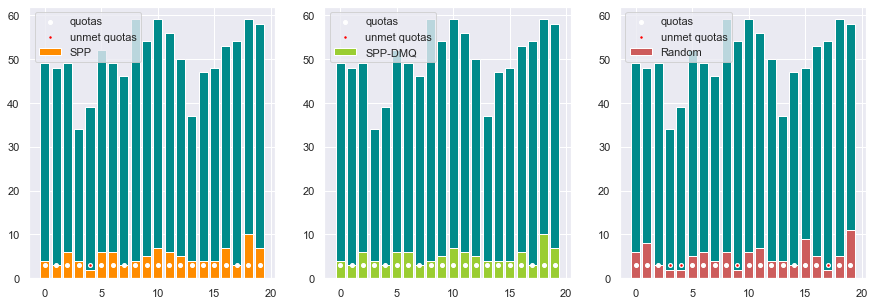

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot_membership_histogram(Memvec, quo, S_s, "darkorange", "darkcyan", budgetlabel="quotas", setlabel="SPP")
plt.subplot(1,3,2)
plot_membership_histogram(Memvec, quo, S_sq, "yellowgreen", "darkcyan", budgetlabel="quotas", setlabel="SPP-DMQ")
plt.subplot(1,3,3)
plot_membership_histogram(Memvec, quo, S_r, "indianred", "darkcyan", budgetlabel="quotas", setlabel="Random")

---

## Submodular : A weighted mixture of m(A)^{0.2}

In [6]:
#%% Marginal gain oracle of the utility

def submodgains(X, modA, fA, aa, mixw):
    """ Returns f(A+a) - f(A)
        Where f(A) = \sum_{j=1}^m (w_j * \phi(\sum_{i \in A} X_{ij}))
    """
    
    modAa = modA + X[aa,:] if aa is not None else modA
    
    # options: modA**0.5, np.log(1+modA), (1-np.exp(-modA)), modA/(1+modA)
    fAa = np.dot(mixw, modAa**0.2)
    
    return fAa - fA


In [7]:
#%% Plain old simple Greedy

def greedygains_submod(V, X, mixw, k):
    """ For a given ground set, a feature matrix and mixture weights which define the objective
        (submodular),
        Returns the greedy selection and step-wise objective values
        Over the addition of k items
    """
    
    [n,m] = X.shape
    
    if V is None:
        V = np.arange(n)
    
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    modA = np.sum(X[A,:], axis=0)
    ff = 0 # assume normalized for now
    objs[0] = ff
    
    for ii in range(k):
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = submodgains(X, modA, ff, V[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
    
    return A, objs


In [8]:
#%% Greedy for DMQ

def greedyDMquota_submod(V, X, mixw, Memvec, quo, k, verbose=False):
    """ For the disjoint membership quota.
        Memvec is an n x p one-hot matrix (exactly one 1 per row).
        quo is a p x 1 vector.
        Output a subset that satisfies the quotas.
    """
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    if V is None:
        V = np.arange(n)
    
    for grp in range(p):
        if np.sum(Memvec[:,grp]) < quo[grp]:
            print("Not enough members in group {}, infeasible problem.".format(grp))
            return None, None
        
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    modA = np.sum(X[A,:], axis=0)
    ff = 0 # assume normalized for now
    objs[0] = ff
    
    """ Quota-filling stage """
    
    ii = 0
    Vsat = np.copy(V) # only for use in the quota-filling stage
    
    # remove from Vsat groups with zero quota
    for grp in range(p):
        if quo[grp] < 1:
            Vsat = np.delete(Vsat, np.argwhere(Memvec[Vsat,grp].flatten()))
    
    while ii < np.sum(quo):
        
        maxgain = -100
        greedyv = np.random.choice(Vsat)
        
        for vidx in range(len(Vsat)):
            gain = submodgains(X, modA, ff, Vsat[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = Vsat[vidx]
        
        # add element to A, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        ff += maxgain
        objs[ii+1] = ff
        
        # remove from V, remove all from Vsat if quota filled
        V = V[V!=greedyv]
        grp = np.argwhere(Memvec[greedyv])

        if verbose:
            print("selected element", greedyv)
            print("lies in group", grp)
            #print("new A", A)

        if np.sum(Memvec[A,grp]) >= quo[grp]:
            if verbose:
                print("\n Quota for group {} satisfied by set {} \n".format(
                        grp, A[Memvec[A,grp].flatten().astype(bool)])
                     )
                print("Deleting {}".format(Vsat[Memvec[Vsat,grp].flatten().astype(bool)]))
            Vsat = np.delete(Vsat, np.argwhere(Memvec[Vsat,grp].flatten()))
        else:
            if verbose:
                print("Only deleting", Vsat[Vsat==greedyv])
            Vsat = Vsat[Vsat!=greedyv]
        
        ii += 1
        
    if verbose:
        print("Quotas filled.")
        print("quotas : ", quo)
        print("Representatives : ", [np.sum(Memvec[A,jj]) for jj in range(p)])
    
    
    """ Regular greedy stage """
    
    while ii < k:
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = submodgains(X, modA, ff, V[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
        
        if verbose:
            print("selected element", greedyv)
            print("lies in group", np.argwhere(Memvec[greedyv]))
            #print("new A", A)
        
        ii += 1
    
    return A, objs


### Run

In [9]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

ground = np.dot(mixw, np.sum(X, axis=0)**0.2)

In [10]:
S, objectives = greedygains_submod(None, X, mixw, k)

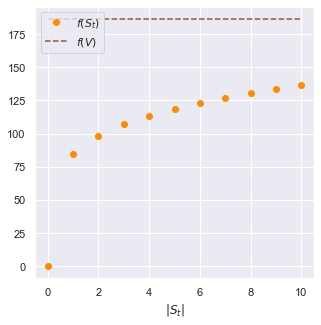

In [11]:
plt.figure(figsize=(5,5))
plot_objective_values(objectives, ground, "darkorange", "sienna")

In [12]:
for oo in objectives: print("{:.3f}".format(oo))

0.000
84.346
98.494
107.093
113.569
118.826
123.244
127.106
130.542
133.648
136.481


---

## Aadhi Quotoba mag Vithoba

Compare:<br>
Feasibility, output quality, computational complexity.

---

<p style="background-color:#ff9933">
Constrained Submodular Max with Disjoint Membership Quota
</p>

In [13]:
n_samples = 1000
m_features = 2
k_budget = 100

np.random.seed(0)
X = np.random.random((n_samples, m_features))

np.random.seed(1)
mixw = np.random.random(m_features); mixw = mixw/np.max(mixw)

In [14]:
p_groups = 20
memcolors = np.array(["#11{:02X}dd".format(pp) for pp in np.arange(0, 256, 256//p_groups)])

In [15]:
#%% Random group assignment

np.random.seed(2)
Memvec = np.eye(p_groups)[np.random.choice(p_groups, n_samples)].astype(int)

#print([len(np.argwhere(Memvec[:,jj])) for jj in range(p_groups)])
print(np.sum(Memvec, axis=0))

#%%Clustering-based group assignment

# kmeans = KMeans(n_clusters=p_groups, random_state=0).fit(X)
# Memvec = np.eye(p_groups)[kmeans.labels_].astype(int)

#%% Viz

# vizpca_DMQ(X, Memvec, memcolors, [], "orange", "Group assignment")

[49 48 49 34 39 52 49 46 59 54 59 56 50 37 47 48 53 54 59 58]


In [19]:
#%% Uniform quota

quo = np.ones(p_groups)*3

#%% Proportionate quota

# quo = np.sum(Memvec, axis=0)*k_budget//n_samples - 3

Objective without quota 3.855625803676566 
 [210 610 632 149 906 516 397 779 702 658 730 878 224 430 775 223 312 382
 284 135 659 281 978 713 726 320 452  82 822 188 577  74 594 317 912 860
 791 584 479  51 192 595 363 601  10 920 238 552 360 837 384 562 762 671
 138 742 559 662 490 493 590 698 269 909 768 872 652 295 546   9 629 511
 812 829 391 150 237 229 432 790 512 850 404 389 970 114 654 174 568 699
  81 587 990 946 814 259 835 439 897 425]
Objective with quota 3.8552007268979565 
 [210 610 632 149 906 516 397 779 702 658 730 878 224 430 775 223 312 382
 284 135 659 281 978 713 726 320 452  82 822 188  74 594 912 791 584  51
 479 192 595 363  10 920 384 762 138 742 559 493 872 295   9 511 812 829
 850 970 568  81 990 402 577 317 860 601 238 360 552 837 562 671 662 490
 590 698 269 909 768 652 546 629 391 150 432 229 237 790 512 404 389 114
 654 174 699 587 814 946 259 835 439 897]
Objective of random selection 3.472983098174264 
 [720 877 309  46 417 940 983 121 546 875 342 273  

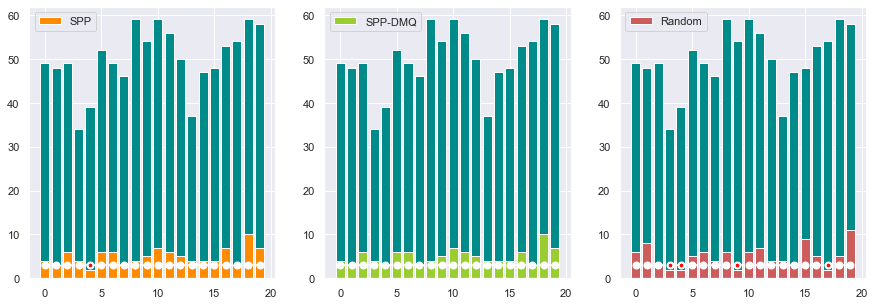

In [20]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k_budget)
S_sq, objectives_sq = subm.greedyDMquota_submod(None, X, mixw, Memvec, quo, k_budget)
S_r = np.random.choice(n_samples, k_budget)
objective_sr = subm.submodgains(X, np.sum(X[S_r,:], axis=0), 0, None, mixw)

print("Objective without quota", objectives_s[-1], "\n", S_s)
print("Objective with quota", objectives_sq[-1], "\n", S_sq)
print("Objective of random selection", objective_sr, "\n", S_r)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot_membership_histogram(Memvec, quo, S_s, "darkorange", "darkcyan", budgetlabel="quotas", setlabel="SPP")
plt.subplot(1,3,2)
plot_membership_histogram(Memvec, quo, S_sq, "yellowgreen", "darkcyan", budgetlabel="quotas", setlabel="SPP-DMQ")
plt.subplot(1,3,3)
plot_membership_histogram(Memvec, quo, S_r, "indianred", "darkcyan", budgetlabel="quotas", setlabel="Random")

In [ ]:
# S_sq, objectives_sq = greedyDMquota_submod(None, X, mixw, Memvec, quo, k_budget, True)

= = = = 

Can we show that there is some benefit to adding _good_ elements _after_ we have met
fairness (here, diversity?! if they are geometrically correlated...) constraints.

We don't want to confuse _good_ with _diverse_. I mean we do want to pick the good ones among the diverse tho...<br>
Is it like -- the group that is picked last gets more quality canditades chosen? and the one that goes first gets filled with token shit??

= = = = 

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
vizpca(X, "darkcyan", S_s, "darkorange", "SPP")
plt.subplot(1,2,2)
vizpca_DMQ(X, Memvec, memcolors, S_sq, "yellowgreen", "SPP-DMQ")

In [ ]:
viztsne_IMQ(X, Memvec, ["lightskyblue", "darkcyan"], S_sq, "yellowgreen", "SPP-DMQ", 30)

---

<p style="background-color:#ff99cc">
Constrained Submodular Max with Intersecting Membership Quota
</p>

In [ ]:
n_samples = 1000
m_features = 50
k_budget = 100

np.random.seed(0)
X = np.random.random((n_samples, m_features))

np.random.seed(1)
mixw = np.random.random(m_features); mixw = mixw/np.max(mixw)

In [ ]:
p_groups = 20
memcolors = np.array(["#11{:02X}dd".format(pp) for pp in np.arange(0, 256, 256//p_groups)])

In [ ]:
#%% Random group assignment

# np.random.seed(2)
# group_probabs = np.random.uniform(0.05, 0.45, p_groups)
# Memvec = np.zeros((n_samples, p_groups)).astype(int)
# for jj in range(p_groups):
#     Memvec[:,jj] = np.random.binomial(1, group_probabs[jj], n_samples)

# print(np.sum(Memvec, axis=0))

#%%Clustering-based group assignment

kmeans = KMeans(n_clusters=p_groups+3, random_state=0).fit(X)
Memvec = np.eye(p_groups+3, p_groups)[kmeans.labels_].astype(int)

np.random.seed(2)
group_probabs = np.random.uniform(0.05, 0.2, p_groups)
for jj in range(p_groups):
    Memvec[:,jj] = np.maximum(Memvec[:,jj], np.random.binomial(1, group_probabs[jj], n_samples))

#%% Viz

# vizpca_DMQ(X, Memvec, memcolors, [], "orange", "Group assignment")

In [ ]:
#%% Uniform quota

# quo = np.ones(p_groups)*2

#%% Proportionate quota

quo = np.sum(Memvec, axis=0)*k_budget//n_samples - 2

In [ ]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k_budget)
S_sq, objectives_sq = subm.greedyIMquota_submod(None, X, mixw, Memvec, quo, k_budget)
S_r = np.random.choice(n_samples, k_budget)
objective_sr = subm.submodgains(X, np.sum(X[S_r,:], axis=0), 0, None, mixw)

print("Objective without quota", objectives_s[-1], "\n", S_s)
print("Objective with quota", objectives_sq[-1], "\n", S_sq)
print("Objective of random selection", objective_sr, "\n", S_r)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_s, "darkorange", "SPP")
plt.subplot(1,3,2)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_sq, "yellowgreen", "SPP-DMQ")
plt.subplot(1,3,3)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_r, "indianred", "Random")

---

<p style="background-color:#ccff66">
Constrained Submodular Max with Feature Quota
</p>